In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.offline as py
template_style = "plotly_dark"
%matplotlib inline

In [2]:
df = pd.read_excel('../Database/basededatos.xlsx')

/Users/isaacmenchaca/PycharmProjects/Tesis/.venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed



# Data Cleaning

##### Remove duplicates and null values  

In [3]:
# the porcentage of missing values is   10,999 - 3.9%
# the porcentage of duplicates is       9,160  - 3.3%
df_without_duplicates = df.drop_duplicates()
df_without_duplicates_and_na = df_without_duplicates.dropna()
# 19008 data removed

##### Convert values to absolute values

In [4]:
df_absolut_values = df_without_duplicates_and_na.copy()
df_absolut_values['tiempo_espera_triage'] = df_without_duplicates_and_na['tiempo_espera_triage'].abs()
df_absolut_values['tiempo_en_triage'] = df_without_duplicates_and_na['tiempo_en_triage'].abs()
df_absolut_values['tiempo_espera_despuestriage'] = df_without_duplicates_and_na['tiempo_espera_despuestriage'].abs()
df_absolut_values['tiempo_en_consulta'] = df_without_duplicates_and_na['tiempo_en_consulta'].abs()
df_absolut_values['edad'] = df_without_duplicates_and_na['edad'].abs()

In [5]:
# create a column with the total time
df_absolut_values['tiempo_total'] = df_absolut_values['tiempo_en_triage'] + df_absolut_values['tiempo_espera_despuestriage'] + df_absolut_values['tiempo_en_consulta']

In [6]:
# remove hora column and change name of 'Fecha' to 'fecha'
df_absolut_values = df_absolut_values.drop(columns=['Hora'])
df_absolut_values.rename(columns={'Fecha':'fecha'}, inplace=True)

##### Outliers for 'tiempo_total' (IQR) interquartile range


In [7]:
# Calculate the percentiles
twenty_fifth = df_absolut_values['tiempo_total'].quantile(0.25)
seventy_fifth = df_absolut_values['tiempo_total'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (10 * iqr)
lower = twenty_fifth - (10 * iqr)

# Subset the dataset
outliers = df_absolut_values[(df_absolut_values['tiempo_total'] < lower) | (df_absolut_values['tiempo_total'] > upper)]

print(f'Number of outliers: {len(outliers)}')

Number of outliers: 791


##### Remove 'tiempo_total' Outliers

In [8]:
# the porcentage of 'tiempo_total' outliers is      726 - 0.2%
df_without_outliers = df_absolut_values.drop(outliers.index)

##### Standardize the value of the age

In [9]:
df_cleaning_edad = df_without_outliers.copy()
df_cleaning_edad.rename(columns={'Edad1': 'edad_unidad'}, inplace=True)
# convert column edad_unidad to numeric.
df_cleaning_edad['edad_unidad'] = df_cleaning_edad['edad_unidad'].replace({'Años': 1, 'Meses': 1/12, 'Dias': 1/365})
# standardize the value of the age
df_cleaning_edad['edad'] = df_cleaning_edad['edad'] * df_cleaning_edad['edad_unidad']

/var/folders/k4/jmfcdlnj0737gj65_12sh9wm0000gn/T/ipykernel_6881/2472631517.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



##### Outliers for 'edad' (IQR)

In [10]:
df_cleaning_edad = df_cleaning_edad.copy()
twenty_fifth = df_cleaning_edad['edad'].quantile(0.25)
seventy_fifth = df_cleaning_edad['edad'].quantile(0.75)

# Obtain IQR
iqr = seventy_fifth - twenty_fifth

# Upper and lower thresholds
upper = seventy_fifth + (1.5 * iqr)
lower = twenty_fifth - (1.5 * iqr)

# Subset the dataset
outliers_edad = df_cleaning_edad[(df_cleaning_edad['edad'] < lower) | (df_cleaning_edad['edad'] > upper)]

print(f'Number of outliers: {len(outliers_edad)}')

Number of outliers: 3


##### Rmove 'edad' Outliers

In [11]:
# the porcentage of 'edad' outliers is      3 - 0.001%
df_without_outliers_edad = df_cleaning_edad.drop(outliers_edad.index)

##### Obtain gender

In [12]:
df_gender_detector = df_without_outliers_edad.copy()
import gender_guesser.detector as gender

# Create an gender detector object
d = gender.Detector()

def obtener_genero(nombre):
    # setting the second name, there is a total categorization between 'Ambiguo' y 'Desconocido' of 34,535 names
    nombre = nombre.split()[-1] 
    nombre = nombre.title()
    # if the name is 'Femenino' or 'Masculino' return the name
    # total categorization between 'Ambiguo' y 'Desconocido' of 27,709 names. Recover 6,826 names
    if nombre == 'Femenino' or nombre == 'Masculino':
        return nombre
    else:
        return d.get_gender(nombre)

df_gender_detector['genero'] = df_gender_detector['nombre'].apply(obtener_genero)

df_gender_detector['genero'] = df_gender_detector['genero'].replace({
    'male': 'Masculino',
    'female': 'Femenino',
    'andy': 'Ambiguo',
    'unknown': 'Desconocido', 
    'mostly_male': 'Masculino',
    'mostly_female': 'Femenino'
})

##### Remove 'Ambiguio' and 'Desconocido' values

In [13]:
df_gender_detector_ambiguo = df_gender_detector[(df_gender_detector['genero'] == 'Ambiguo') | (df_gender_detector['genero'] == 'Desconocido')]
# Drop 'Ambiguio' and 'Desconocido' values
# the porcentage of 'df_gender_detector_ambiguo' is      27,709 - 9.9%
df_gender_detector_clean = df_gender_detector.drop(df_gender_detector_ambiguo.index)

##### Encode gender and clasification

In [14]:
# Encode calsification of triage
df_encode = df_gender_detector_clean.copy()
df_encode['clasificacion'] = df_encode['clasificacion'].astype('category').cat.codes
# Encode gender. 0: Femenino 1: Masculino
df_encode['genero_encode'] = df_encode['genero'].astype('category').cat.codes

In [15]:
# from sklearn.preprocessing import OneHotEncoder
# df_encode = df_gender_detector_clean.copy()

# # Codificar la columna 'genero' usando OneHotEncoder
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# genero_encoded = encoder.fit_transform(df_encode[['genero']])
# # Añadir las columnas codificadas al DataFrame original
# df_encode = df_encode.join(pd.DataFrame(genero_encoded, columns=encoder.get_feature_names_out(['genero'])))


# clasificacion_encoded = encoder.fit_transform(df_encode[['clasificacion']])
# df_encode = df_encode.join(pd.DataFrame(clasificacion_encoded, columns=encoder.get_feature_names_out(['clasificacion'])))

##### Date

In [16]:
df_date = df_encode.copy()
# Extract caracteristics from date
df_date['hora'] = df_date['fecha'].dt.hour
df_date['minuto'] = df_date['fecha'].dt.minute
df_date['mes'] = df_date['fecha'].dt.month
df_date['dia'] = df_date['fecha'].dt.day
df_date['dia_semana'] = df_date['fecha'].dt.dayofweek
df_date.dtypes

fecha                          datetime64[ns]
nombre                                 object
tiempo_espera_triage                  float64
tiempo_en_triage                      float64
tiempo_espera_despuestriage           float64
tiempo_en_consulta                    float64
clasificacion                            int8
edad                                  float64
edad_unidad                           float64
Dx                                     object
tiempo_total                          float64
genero                                 object
genero_encode                            int8
hora                                    int32
minuto                                  int32
mes                                     int32
dia                                     int32
dia_semana                              int32
dtype: object

In [17]:
df_date.head()

,fecha,nombre,tiempo_espera_triage,tiempo_en_triage,tiempo_espera_despuestriage,tiempo_en_consulta,clasificacion,edad,edad_unidad,Dx,tiempo_total,genero,genero_encode,hora,minuto,mes,dia,dia_semana
0,2010-08-16 08:46:15.343,JORGE,7.0,5.0,18.0,14.0,0,42.0,1.0,HERIDA DEL LABIO SUPERIOR,37.0,Masculino,1,8,46,8,16,0
1,2010-08-16 09:00:35.700,MARIA TERESITA,4.0,5.0,16.0,26.0,0,45.0,1.0,PICADURA DE APIE,47.0,Femenino,0,9,0,8,16,0
5,2010-08-16 09:37:31.500,JONATHAN BRAYAN,5.0,5.0,51.0,13.0,0,8.0,1.0,FRACTURA DE TERCIO MEDIO CLAVICULA IZQ,69.0,Masculino,1,9,37,8,16,0
7,2010-08-16 09:44:29.467,ALMA PATRICIA,5.0,4.0,44.0,0.0,0,33.0,1.0,COLICO RENOURETERAL REMITIDO + PB UROLITIASIS ...,48.0,Femenino,0,9,44,8,16,0
8,2010-08-16 09:49:16.543,ROBERTO,27.0,5.0,71.0,9.0,0,34.0,1.0,COLICO RENAL IZQ,85.0,Masculino,1,9,49,8,16,0


# Regression Model

In [18]:
df_regresion = df_date.copy()

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Select target and features
X = df_regresion[['clasificacion', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana', 'tiempo_espera_triage']]
# X = df_regresion[['clasificacion', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta']]
# X = df_regresion[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
y = df_regresion['tiempo_total']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Predicciones
y_test_pred = model.predict(X_test)

# Métricas de evaluación
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

Mean Squared Error (MSE): 1076.0160581397759
Coeficiente de determinación (R^2): 0.06671057599674712
Mean Absolute Error (MAE): 22.2948280525463
Root Mean Squared Error (RMSE): 32.802683703315736


In [23]:
# from lazypredict.Supervised import LazyRegressor
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # Supongamos que tienes un DataFrame llamado df_ann
# X = df_regresion[['clasificacion', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# # X = df_regresion[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# y = df_regresion['tiempo_total']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

In [24]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt


# # Select target and features
# X = df_regresion[['clasificacion', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# # X = df_regresion[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# y = df_regresion['tiempo_total']

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = KNeighborsRegressor()
# param_grid = {'n_neighbors': [90, 95, 100]}

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
# grid_search.fit(X_train, y_train)

# # Obtener los mejores hiperparámetros
# best_params = grid_search.best_params_
# print("Mejores hiperparámetros:", best_params)

# # Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
# best_model = grid_search.best_estimator_

# # Predicciones
# y_test_pred = best_model.predict(X_test)

Mean Squared Error (MSE): 1076.0160581397759
Coeficiente de determinación (R^2): 0.06671057599674712
Mean Absolute Error (MAE): 22.2948280525463
        Actual  Predicted
167727    35.0  39.002691
44902     52.0  43.109129
200519    39.0  42.288624
55906     49.0  44.460348
180041    35.0  47.122898
244944   102.0  71.945586
264151    24.0  33.270180
77338    104.0  50.142188
37094     12.0  52.762775
42211     39.0  56.216602


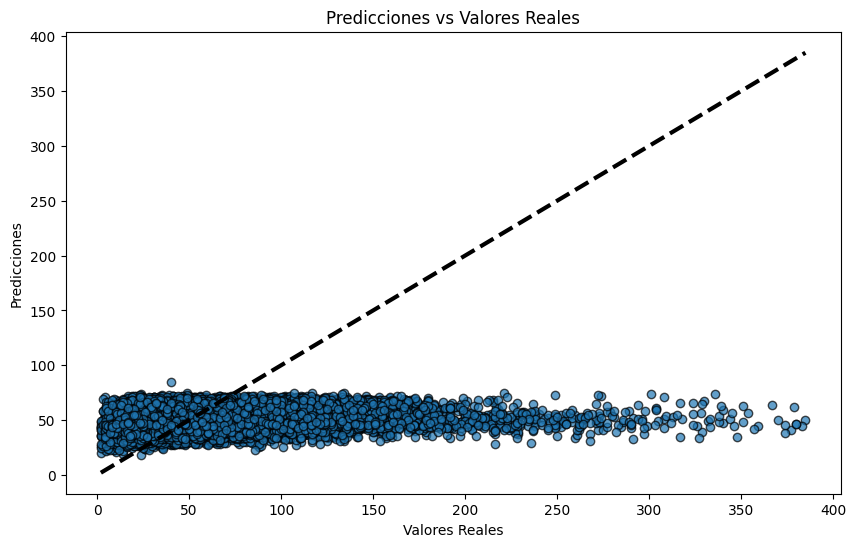

In [20]:
# Métricas de evaluación
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.show()

# ANN Model

In [41]:
df_ann = df_date.copy()

In [42]:
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
import numpy as np

# Select target and features
X = df_ann[['clasificacion', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
# X = df_ann[['clasificacion', 'edad', 'genero_encode', 'hora', 'minuto', 'mes', 'dia', 'dia_semana', 'tiempo_espera_triage', 'tiempo_en_triage', 'tiempo_espera_despuestriage', 'tiempo_en_consulta']]
# X = df_ann[['clasificacion_AMARILLO', 'clasificacion_ROJO', 'clasificacion_VERDE', 'edad', 'genero_Femenino', 'genero_Masculino', 'hora', 'minuto', 'mes', 'dia', 'dia_semana']]
y = df_ann['tiempo_total']

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Configurar la semilla para reproducibilidad
np.random.seed(3000)

# Construcción de la red neuronal
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(420, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense (198, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense(98, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.1))
model.add(Dense(1))

# Inicializar el optimizador con una tasa de aprendizaje inicial
initial_learning_rate = 0.0001
optimizer = RMSprop(learning_rate=initial_learning_rate)
#MSprop (Root Mean Square Propagation) es una extensión del método de descenso del gradiente estocástico (SGD)
#que ajusta la tasa de aprendizaje para cada parámetro de forma individual
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Entrenar el modelo
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr, model_checkpoint])

# Evaluación del modelo
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Mean Absolute Error on test data: {mae}')

Epoch 1/100


/Users/isaacmenchaca/PycharmProjects/Tesis/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9243/9249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1470.7406 - mae: 26.0590
Epoch 1: val_loss improved from inf to 1233.29321, saving model to best_model.keras
9249/9249 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1470.6449 - mae: 26.0581 - val_loss: 1233.2932 - val_mae: 24.5769 - learning_rate: 1.0000e-04
Epoch 2/100
9249/9249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1312.9254 - mae: 24.3977
Epoch 2: val_loss improved from 1233.29321 to 1232.17847, saving model to best_model.keras
9249/9249 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1312.9241 - mae: 24.3977 - val_loss: 1232.1785 - val_mae: 23.3655 - learning_rate: 1.0000e-04
Epoch 3/100
9231/9249 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1271.1561 - mae: 24.1806
Epoch 3: val_loss improved from 1232.17847 to 1226.21204, saving model to best_model.keras
9249/9249 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1271.2068 - mae: 24.1807 - val_loss: 1226.2120 - val_mae: 23.6932 - learning_rate: 1.0000e-04
Epoch 4/100
9229/9249 ━━━━━━━━━━━━━━━━━━━━ 0

1446/1446 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step
        Actual  Predicted
128213    31.0  54.717484
87574     72.0  57.295227
166331    85.0  55.383652
166380    62.0  55.786884
239498    18.0  40.809895
247839    56.0  55.556076
105725    18.0  52.990158
142604    68.0  50.673664
126600    81.0  45.652756
56035     36.0  52.267673
Mean Absolute Error: 23.743496656319884
dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'learning_rate'])


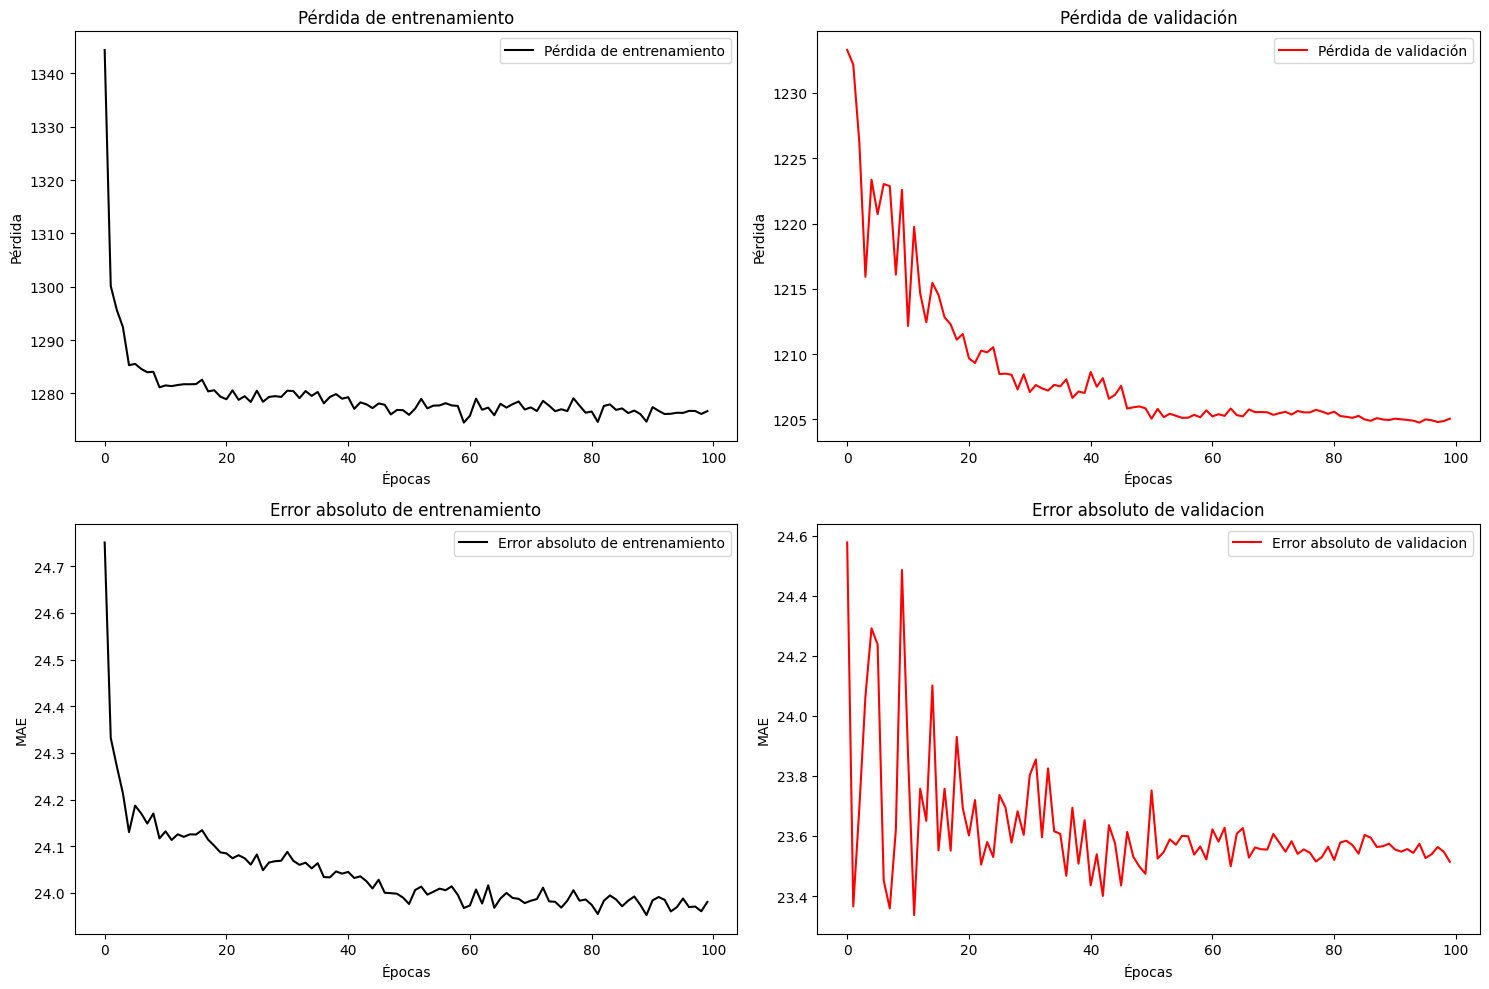

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Predicción
y_pred = model.predict(X_test)

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(predictions.head(10))

# Calcular métricas adicionales
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Imprimir las claves de history.history
print(history.history.keys())

import matplotlib.pyplot as plt


# Crear subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Graficar la pérdida de entrenamiento
axs[0, 0].plot(history.history['loss'], label='Pérdida de entrenamiento', color="black")
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Pérdida')
axs[0, 0].set_title('Pérdida de entrenamiento')
axs[0, 0].legend()

# Graficar la pérdida de validación
axs[0, 1].plot(history.history['val_loss'], label='Pérdida de validación',color="red")
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Pérdida')
axs[0, 1].set_title('Pérdida de validación')
axs[0, 1].legend()

# Graficar MAE de entrenamiento
axs[1, 0].plot(history.history['mae'], label='Error absoluto de entrenamiento', color="black")
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_title('Error absoluto de entrenamiento')
axs[1, 0].legend()

# Graficar MAE de validación
axs[1, 1].plot(history.history['val_mae'], label='Error absoluto de validacion', color="red")
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].set_title('Error absoluto de validacion')
axs[1, 1].legend()

# Ajustar diseño para evitar solapamiento
plt.tight_layout()
plt.show()

# Analisys

##### Prepare data

In [26]:
df_analisys = df_encode.copy()

In [27]:
df_analisys.rename(columns={'fecha':'date'}, inplace=True)

df_analisys['entry_time'] = df_analisys['date'].dt.time
df_analisys['entry_time'] = pd.to_timedelta(df_analisys.entry_time.astype(str))


df_analisys.rename(columns={'tiempo_total':'waiting_time'}, inplace=True)
df_analisys['waiting_time'] = pd.to_timedelta(df_analisys['waiting_time'], unit='m')

df_analisys['completion_time'] = df_analisys['waiting_time'] + df_analisys['entry_time']

df_analisys['waiting_ber_munets'] = df_analisys.waiting_time.dt.seconds / 60
df_analisys['waiting_ber_munets'] = df_analisys['waiting_ber_munets'].round(0)

df_analisys['weekday'] = df_analisys.date.dt.strftime('%A')                      # new column for extract 'weekday' from 'date'
df_analisys['hours'] = df_analisys.entry_time.dt.components.hours                # new column for extract the  'hours' from 'entry_time'

In [28]:
df_analisys.dtypes

date                            datetime64[ns]
nombre                                  object
tiempo_espera_triage                   float64
tiempo_en_triage                       float64
tiempo_espera_despuestriage            float64
tiempo_en_consulta                     float64
clasificacion                             int8
edad                                   float64
edad_unidad                            float64
Dx                                      object
waiting_time                   timedelta64[ns]
genero                                  object
genero_encode                             int8
entry_time                     timedelta64[ns]
completion_time                timedelta64[ns]
waiting_ber_munets                     float64
weekday                                 object
hours                                    int64
dtype: object

In [29]:
df_analisys.drop(columns=['nombre', 'genero', 'Dx'], inplace=True)
df_analisys.head(2)

,date,tiempo_espera_triage,tiempo_en_triage,tiempo_espera_despuestriage,tiempo_en_consulta,clasificacion,edad,edad_unidad,waiting_time,genero_encode,entry_time,completion_time,waiting_ber_munets,weekday,hours
0,2010-08-16 08:46:15.343,7.0,5.0,18.0,14.0,0,42.0,1.0,0 days 00:44:00,1,0 days 08:46:15.343000,0 days 09:30:15.343000,44.0,Monday,8
1,2010-08-16 09:00:35.700,4.0,5.0,16.0,26.0,0,45.0,1.0,0 days 00:51:00,0,0 days 09:00:35.700000,0 days 09:51:35.700000,51.0,Monday,9


##### Patient heatmap

In [30]:

def grouped_data2(column_name):
    if column_name == 'completion_time':                                            
        answer = pd.pivot_table(df_analisys, index='hours', columns=['weekday'], aggfunc='count')
    elif column_name == 'waiting_ber_munets':                                      
        answer = pd.pivot_table(df_analisys, index='hours',                                  
                                columns=['weekday'] , aggfunc='mean').round(1)  
    else:
        return(column_name + " is not in the columns")                              
    
    answer = answer[column_name]
    answer = answer.fillna(0)
    answer = answer[['Sunday', 'Monday', 'Tuesday',                                
                  'Wednesday', 'Thursday', 
                  'Friday', 'Saturday']] 
    return answer
answer3 =  grouped_data2('completion_time')
answer4 =  grouped_data2('waiting_ber_munets')
print(answer3,answer4)

weekday  Sunday  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday
hours                                                                  
0          1359    1294     1079       1065      1093    1126      1192
1          1193     950      751        724       665     736       861
2           939     718      519        535       485     579       626
3           883     557      461        453       417     461       561
4           776     482      388        397       336     412       465
5           560     354      343        358       330     339       398
6           500     403      401        375       342     357       376
7           558     897      777        815       748     709       581
8           827    1824     1538       1646      1508    1458       848
9          1056    2036     1806       1749      1705    1626      1070
10         1354    2369     2103       1973      1865    1864      1420
11         1594    2494     2077       2034      2064    1911   

In [31]:
fig3 = px.imshow(answer3,
                labels=dict(x="weekday", y="hours", color="number of paitant") , 
                aspect="auto", color_continuous_scale='tempo',
                template = template_style,
                text_auto=True, width=900, height=900)
fig3.update_xaxes(side="top")
fig3.show()

##### Hour heatmap

In [32]:
fig4 = px.imshow(answer4,
                labels=dict(x="weekday", y="hours",
                            color="the waiting time per min") , 
                            aspect="auto", color_continuous_scale='tempo',
                            template = template_style,
                            text_auto=True, width=900, height=900)
fig4.update_xaxes(side="top")
fig4.show()

##### Bar chart

In [33]:
def grouped_data(column_name):
    '''
    Groupby column and return DataFrame
    Input: Column Name
    '''
    df_tmp = df_analisys.groupby(column_name)[['waiting_ber_munets']].mean().round(0)
    df_tmp2 = df_analisys[column_name].value_counts()      #this for concat
    
    pivot_f = pd.concat([df_tmp, df_tmp2.rename('number_of_patient')],axis=1)
    pivot_f.reset_index(inplace=True)
    pivot_f = pivot_f.rename(columns={'index': column_name })
    return pivot_f

answer5 = grouped_data('hours')
link_size = [3,6]
fig = px.bar(x=answer5['hours'],
             y=answer5['waiting_ber_munets'],
             template= template_style,
             text_auto='.2s',
             labels={'x':'the hour',
                     'y':'the waiting time per m'}
             ).add_traces(
      px.line(answer5, x=answer5['hours'], text='number_of_patient',
             y=answer5['number_of_patient'],markers=True).update_traces(yaxis="y2",
             showlegend=True, line=dict(color = 'red', width=link_size[1]), name="number_of_patient").data)        
fig.update_layout(yaxis2={"side":"right", "overlaying":"y"})
fig.show()

##### Weekly chart

In [34]:
answer2 =  grouped_data('weekday')
# Create Chart for the Daily
fig2 = px.bar(answer2,
             x='weekday',
             y='number_of_patient',
             color='waiting_ber_munets',
             labels={'waiting_ber_munets':'the waiting time per m'} ,
             color_continuous_scale=['green','yellow','red'],
             template = template_style,
             title = '<b>Daily visualization</b>')
# Display Plot
fig2.show()

# Results